In [1]:
import pandas as pd
import geopandas as gpd 
import numpy as np
from typing import Dict, Set, List

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import constants as c 
import helpers as h
from logger import setup_logger 

log = setup_logger("floodnet-sensor-placement-algorithm")
log.setLevel("INFO")
log.info("Modules loaded.")

h.latex(True)


2025-02-07 18:41:17 - floodnet-sensor-placement-algorithm - INFO - Modules loaded.
2025-02-07 18:41:17 - analysis-helpers - INFO - Enabling LaTeX for matplotlib.


In [2]:
ct_nyc = gpd.read_file(f"{c.GEO_PATH}/ct-nyc-2020.geojson", crs=c.WGS).to_crs(c.PROJ)

In [3]:
def optimize_sensor_placement(
    df: pd.DataFrame,
    n_new_sensors: int,
    adjacency_map: Dict[int, Set[int]],
    r: int = 1
    ) -> List[int]:
    working_df = df.copy()
    selected_tracts = []
    total_py_covered = 0

    def get_coverage(tract_id: int, radius: int) -> Set[int]:
        covered = {tract_id}
        frontier = {tract_id}
        
        for step in range(radius):
            new_frontier = set()
            for t in frontier:
                new_frontier.update(adjacency_map.get(t, set()))
            covered.update(new_frontier)
            frontier = new_frontier
            log.debug(f"Step {step+1}: Added {len(new_frontier)} tracts to coverage")
            
        return covered
   
    def score_placement(tract_id: int) -> float:
        if working_df.loc[working_df['BoroCT2020'] == tract_id, 'n_floodnet_sensors'].iloc[0] > 0:
            return -np.inf
            
        covered = get_coverage(tract_id, r)
        covered_tracts = working_df[working_df['BoroCT2020'].isin(covered)]
        
        score = covered_tracts[
            covered_tracts['n_floodnet_sensors'] == 0
        ]['p_y'].sum()
        
        log.debug(f"Tract {tract_id} would cover {len(covered)} tracts with score {score:.4f}")
        return score

    log.info(f"Starting placement of {n_new_sensors} sensors with radius {r}")
    log.info(f"Initial p_y coverage: {working_df[working_df['n_floodnet_sensors'] > 0]['p_y'].sum():.4f}")
    
    for i in range(n_new_sensors):
        scores = []
        for tract_id in working_df['BoroCT2020']:
            scores.append((tract_id, score_placement(tract_id)))
            
        best_tract, best_score = max(scores, key=lambda x: x[1])
        
        if best_score == -np.inf:
            log.info("No more valid placements available")
            break
            
        selected_tracts.append(best_tract)
        
        covered = get_coverage(best_tract, r)
        working_df.loc[
            working_df['BoroCT2020'].isin(covered),
            'n_floodnet_sensors'
        ] = 1
        
        new_total = working_df[working_df['n_floodnet_sensors'] > 0]['p_y'].sum()
        py_added = new_total - total_py_covered
        total_py_covered = new_total
        
        log.info(f"Placed sensor {i+1} at tract {best_tract}")
        log.info(f"Added p_y coverage: {py_added:.4f}")
        log.info(f"Total p_y coverage: {total_py_covered:.4f}")
        log.info(f"Newly covered tracts: {len(covered)}")
        
    log.info(f"Final p_y coverage: {total_py_covered:.4f}")
    log.info(f"Selected tracts: {selected_tracts}")
    
    return selected_tracts

In [4]:
analysis_df = pd.read_csv(c.CURRENT_DF)
analysis_df['og_sensor_count'] = analysis_df['n_floodnet_sensors']

In [5]:
def build_adjacency_map(node1_file: str, node2_file: str, df: pd.DataFrame) -> Dict[int, Set[int]]:
    # Read node files
    with open(node1_file) as f1, open(node2_file) as f2:
        node1 = [int(x) for x in f1.readlines()]
        node2 = [int(x) for x in f2.readlines()]
    
    # Create mapping from index to tract ID
    tract_ids = df['BoroCT2020']
    idx_to_tract = {i+1: tract for i, tract in enumerate(tract_ids)}
    
    # Build adjacency map using actual tract IDs
    adj_map = {}
    for n1, n2 in zip(node1, node2):
        tract1 = idx_to_tract[n1]
        tract2 = idx_to_tract[n2]
        
        if tract1 not in adj_map:
            adj_map[tract1] = set()
        if tract2 not in adj_map:
            adj_map[tract2] = set()
            
        adj_map[tract1].add(tract2)
        adj_map[tract2].add(tract1)
    
    return adj_map

# Use this to create the adjacency map
adj_map = build_adjacency_map(c.CURRENT_ADJ_1, c.CURRENT_ADJ_2, analysis_df)

In [6]:
new_sensor_locations = optimize_sensor_placement(analysis_df, 25, adj_map, r=1)

2025-02-07 18:41:18 - floodnet-sensor-placement-algorithm - INFO - Starting placement of 25 sensors with radius 1
2025-02-07 18:41:18 - floodnet-sensor-placement-algorithm - INFO - Initial p_y coverage: 3.2492
2025-02-07 18:41:19 - floodnet-sensor-placement-algorithm - INFO - Placed sensor 1 at tract 3032600
2025-02-07 18:41:19 - floodnet-sensor-placement-algorithm - INFO - Added p_y coverage: 4.5072
2025-02-07 18:41:19 - floodnet-sensor-placement-algorithm - INFO - Total p_y coverage: 4.5072
2025-02-07 18:41:19 - floodnet-sensor-placement-algorithm - INFO - Newly covered tracts: 7
2025-02-07 18:41:20 - floodnet-sensor-placement-algorithm - INFO - Placed sensor 2 at tract 4107202
2025-02-07 18:41:20 - floodnet-sensor-placement-algorithm - INFO - Added p_y coverage: 0.4605
2025-02-07 18:41:20 - floodnet-sensor-placement-algorithm - INFO - Total p_y coverage: 4.9677
2025-02-07 18:41:20 - floodnet-sensor-placement-algorithm - INFO - Newly covered tracts: 5
2025-02-07 18:41:21 - floodnet-s

In [7]:
ct_nyc['selected'] = 0
ct_nyc['selected_order'] = 0
ct_nyc['BoroCT2020'] = ct_nyc['BoroCT2020'].astype(int)

for i, tract in enumerate(new_sensor_locations):
    ct_nyc.loc[ct_nyc['BoroCT2020'] == tract, 'selected'] = 1
    ct_nyc.loc[ct_nyc['BoroCT2020'] == tract, 'selected_order'] = i + 1


In [8]:
# add p_y to ct_nyc 
ct_nyc['p_y'] = analysis_df['p_y']

In [9]:
ct_nyc['n_added_sensors'] = 0
ct_nyc.loc[ct_nyc['selected'] == 1, 'n_added_sensors'] = 1

In [10]:
# load floodnet geo 
floodnet_sensors_sep23 = pd.read_csv("/share/ju/matt/street-flooding/aggregation/flooding/static/sep23_floodnet_sensor_coordinates.csv")
floodnet_sensors_sep23 = gpd.GeoDataFrame(floodnet_sensors_sep23, geometry=gpd.points_from_xy(floodnet_sensors_sep23['lon'], floodnet_sensors_sep23['lat']), crs=c.WGS).to_crs(c.PROJ)

floodnet_sensors_current = pd.read_csv("/share/ju/matt/street-flooding/aggregation/flooding/static/current_floodnet_sensors.csv")
floodnet_sensors_current = gpd.GeoDataFrame(floodnet_sensors_current, geometry=gpd.points_from_xy(floodnet_sensors_current['longitude'], floodnet_sensors_current['latitude']), crs=c.WGS).to_crs(c.PROJ)

# drop a sensor from floodnet_sensors_current if it is within THRES Ft of another 
log.info(f"Current floodnet sensors: {len(floodnet_sensors_current)}")
THRES = 10
for idx, row in floodnet_sensors_current.iterrows():
    for idx2, row2 in floodnet_sensors_current.iterrows():
        if idx == idx2:
            continue 
        if row['geometry'].distance(row2['geometry']) < THRES:
            floodnet_sensors_current.drop(idx, inplace=True)
            log.info(f"Dropped sensor {idx} from current floodnet sensors")
            break 
log.info(f"Current floodnet sensors after filtering for duplicates: {len(floodnet_sensors_current)}")

2025-02-07 18:41:41 - floodnet-sensor-placement-algorithm - INFO - Current floodnet sensors: 254


2025-02-07 18:41:42 - floodnet-sensor-placement-algorithm - INFO - Dropped sensor 116 from current floodnet sensors
2025-02-07 18:41:43 - floodnet-sensor-placement-algorithm - INFO - Current floodnet sensors after filtering for duplicates: 253


/share/ju/conda_virtualenvs/urbanekg/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/share/ju/conda_virtualenvs/urbanekg/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/share/ju/conda_virtualenvs/urbanekg/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy

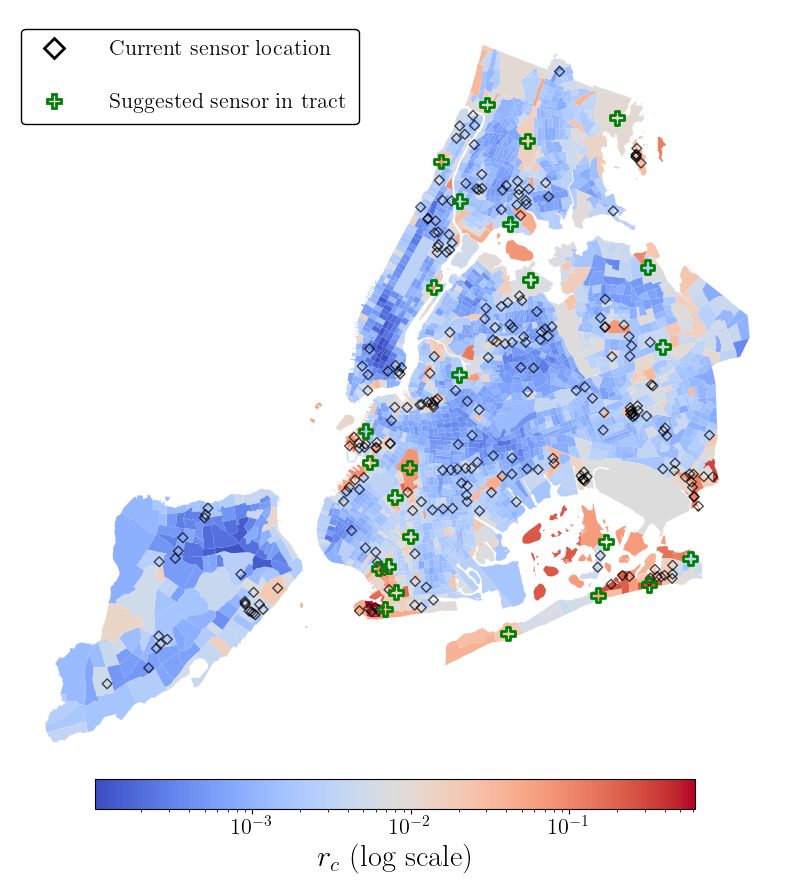

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all tracts in light gray
#ct_nyc.plot(ax=ax, color='lightgray', edgecolor='white', linewidth=0.5)

# Plot selected tracts with color
mask = ct_nyc['selected_order'] > 0
selected_tracts = ct_nyc[mask]

# plot p_y  with log colormap 
lognorm = LogNorm(vmin=ct_nyc['p_y'].min(), vmax=ct_nyc['p_y'].max())
im = ct_nyc.plot(ax=ax, column='p_y', cmap='coolwarm', norm=lognorm, legend=False)
mappable = im.collections[0]  # Get the actual mappable object

# Create centered colorbar
cax = fig.add_axes([0.21, 0.08, 0.6, 0.03])
cbar = plt.colorbar(mappable, cax=cax, orientation='horizontal')
cbar.set_label(r"$r_c$ (log scale)", size=22)
cbar.ax.tick_params(labelsize=16)

# plot sep23 floodnet 
#floodnet_sensors_sep23.plot(ax=ax, facecolor='none', edgecolor='black', markersize=25, marker='D', alpha=1)

# plot floodnet 
floodnet_sensors_current.plot(ax=ax,facecolor='none', edgecolor='black', markersize=25, marker='D', alpha=0.7)

# plot 'added' floodnet census via the centroid of each selected_tract 
selected_tracts['centroid'] = selected_tracts.centroid
# plot 
# dynamic edge color 
# if the tract has both an added sensor and a predicted sensor, then make the edge color green 
# if the tract has only a predicted sensor, then make the edge color black
selected_tracts['edge_color'] = 'green'
# also do dynbamic marker size
selected_tracts['marker_size'] = 100
# use dybnamic line width
selected_tracts['line_width'] = 2
# print the number of tracts with both added and predicted sensors
selected_tracts['centroid'].plot(ax=ax, facecolor='none', markersize=selected_tracts['marker_size'], marker="P", edgecolor=selected_tracts['edge_color'], linewidth=selected_tracts['line_width'])

# custom legend for floodnet sensors
# use Line2D for markers

# Create legend with padding and modified bbox
legend_elements = [
    plt.Line2D([0], [0], marker='D', color='black', label='Current sensor location',
               markerfacecolor='none', markeredgewidth=2, markersize=10, linestyle='None'),
    plt.Line2D([0], [0], marker='P', color='green', label='Suggested sensor in tract',
               markerfacecolor='none', markeredgewidth=2, markersize=10, linestyle='None'),
]

# Add legend with padding via borderpad and borderaxespad
ax.legend(handles=legend_elements, 
         loc='upper left', 
         fontsize=16,
         bbox_to_anchor=(0.00, 0.99),
         handletextpad=1.5,
         labelspacing=1.5,
         borderpad=0.5,        # Padding between legend edge and content
         borderaxespad=0.5,    # Padding between legend edge and axes
         framealpha=1,         # Make background fully opaque
         edgecolor='black')    # Add border for clarity

# label the selected order 
#for i, row in selected_tracts.iterrows():
#    ax.text(row['centroid'].x - 1000, row['centroid'].y - 1000, row['selected_order'], fontsize=18, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))

ax.set_axis_off()

plt.savefig(f"{c.PAPER_PATH}/figures/sensor_placement.png", dpi=150, bbox_inches='tight', pad_inches=0.025)  